# Reading in the data

In [1]:
# Import libraries
import pandas as pd
import dill
import numpy as np
from sklearn.metrics import f1_score

In [2]:
# Read in the data from the  huggingface library

#splits = {'validation': 'en/validation-00000-of-00001.parquet', 'test': 'en/test-00000-of-00001.parquet', 'train': 'en/train-00000-of-00001.parquet'}
#train = pd.read_parquet("hf://datasets/unimelb-nlp/wikiann/" + splits["train"])
#val = pd.read_parquet("hf://datasets/unimelb-nlp/wikiann/" + splits["validation"])
#test = pd.read_parquet("hf://datasets/unimelb-nlp/wikiann/" + splits["test"])

In [3]:
# Extract 2000 rows from the training data

#subset=train[train.index % 10 == 0].copy()
#subset=subset[['tokens', 'ner_tags']]

In [4]:
#subset.to_csv('subset_file.csv', index=False, encoding='UTF-8', sep=';')
#with open('subset_of_wikiann.pkl', 'wb') as f:
#    dill.dump(subset, f)

In [5]:
#silver_data=pd.read_csv('subset_file.csv', sep=';', encoding='UTF-8')
with open('subset_of_wikiann.pkl', 'rb') as f:
    silver_data=dill.load(f)

In [6]:
# Convert each list of tokens to a readable string

sentences=[]
for index, row in silver_data.iterrows():
    sent=" ".join(row['tokens'])
    sent="# New sentence = "+sent
    sentences.append(sent)

In [7]:
# Add the sentence strings before each list of strings row in the dataframe

expanded=silver_data.copy()
for i, sentence in reversed(list(enumerate(sentences))):
    line=pd.DataFrame({'tokens':sentence, 'ner_tags':[0], 'langs':['en'], 'spans':['']})
    expanded=pd.concat([expanded.iloc[:i], line, expanded.iloc[i:]]).reset_index(drop=True)

In [8]:
all_tokens=expanded.explode('tokens')
toks=all_tokens['tokens']
# toks.to_csv('gathered_results.csv', index=False, encoding='UTF-8', sep=';')

# Dividing it between us

In [9]:
A=expanded[0:1000]
B=expanded[1000:2000]
C=expanded[2000:3000]
D=expanded[3000:4000]

In [10]:
Am=pd.concat([A, D])
Amina=Am.explode('tokens')
Amina['labels']=0
Amina=Amina[['tokens', 'labels']]
# Amina.to_csv('Amina_annotations.csv', index=False, encoding='UTF-8', sep=';')

In [11]:
Li=pd.concat([A,B])
Lilja=Li.explode('tokens')
Lilja['labels']=0
Lilja=Lilja[['tokens', 'labels']]
# Lilja.to_csv('Lilja_annotations.csv', index=False, encoding='UTF-8', sep=';')

In [12]:
Mi=pd.concat([B,C])
Miko=Mi.explode('tokens')
Miko['labels']=0
Miko=Miko[['tokens', 'labels']]
# Miko.to_csv('Mikolaj_annotations.csv', index=False, encoding='UTF-8', sep=';')

In [13]:
Zo=pd.concat([C,D])
Zosia=Zo.explode('tokens')
Zosia['labels']=0
Zosia=Zosia[['tokens', 'labels']]
# Zosia.to_csv('Zosia_annotations.csv', index=False, encoding='UTF-8', sep=';')

# Reading the results back in

In [14]:
results=pd.read_csv('results.csv', sep=';', encoding='utf-8')

In [15]:
results=results.fillna('0')
results['labels1']=results['labels1'].astype(int)
results['labels2']=results['labels2'].astype(int)
results['labels1']=results['labels1'].astype(str)
results['labels2']=results['labels2'].astype(str)

In [16]:
sentence=''
YAY=0
FALSEPOSNEG=0
ORGLOCERR=0
LOCSPLITERR=0
locspliterrlist=[]
OTHERERR=0
weird_results=[]
annotator1_results=[]
annotator2_results=[]

location=False
for index, row in results.iterrows():
    
    token=row.iloc[0]
    label1=row.iloc[1]
    label2=row.iloc[2]
    
    if token[0]=='#':
        sentence=token[17:]
        continue
    annotator1_results.append(label1)
    annotator2_results.append(label2)
    
    if label1 == label2:
        YAY +=1
        
    else:
        if ( ( label1 in ['3','4'] ) and (label2 in ['5','6'] ) ) or ( ( label2 in ['3','4'] ) and (label1 in ['5','6'] ) ):
            ORGLOCERR+=1

        elif label1=='5' or label2=='5':
            location=True
            if label1=='0' or label2=='0':
                FALSEPOSNEG+=1
                continue
                
        elif ( label1=='0' and label2 in ['5','6'] ) or ( label2=='0' and label1 in ['5','6'] ) or (label1 in ['5', '6'] and label2 in ['5', '6']):
            LOCSPLITERR+=1
            locspliterrlist.append((sentence, token, label1, label2))

        elif label1=='0' or label2=='0':
            FALSEPOSNEG+=1
            #print(sentence, token, label1, label2, "\n")
        else:
            OTHERERR+=1
            weird_results.append((sentence, token, label1, label2))

In [17]:
print("Correct results: ", YAY)
print("False positives or negatives: ", FALSEPOSNEG)
print("Disagreements of organisation or location: ", ORGLOCERR)
print("Location-splitting error (or perhaps just false negatives): ", LOCSPLITERR)
print("Nr of other unidentified errors: ", OTHERERR)

Correct results:  14260
False positives or negatives:  412
Disagreements of organisation or location:  317
Location-splitting error (or perhaps just false negatives):  376
Nr of other unidentified errors:  81


# Accuracy and Cohen's Kappa

In [18]:
# Function to calculate accuracy between two lists of labels
def calculate_accuracy(labels1, labels2):
    total_tokens = len(labels1)
    correct_tokens = sum(1 for label1, label2 in zip(labels1, labels2) if label1 == label2)
    accuracy = correct_tokens / total_tokens
    return accuracy

# Calculate accuracy
accuracy = calculate_accuracy(results['labels1'], results['labels2'])
print("Accuracy:", accuracy)

Accuracy: 0.917075647317651


In [19]:
from collections import Counter

def cohen_kappa(annotation1, annotation2):
    #how much of each annotation
    count1 = Counter(annotation1)
    count2 = Counter(annotation2)
    
    # Observed agreement (P_o)
    observed_agreement = sum((a == b) for a, b in zip(annotation1, annotation2)) / len(annotation1)
    
    # Expected agreement (P_e)
    total = len(annotation1)
    categories = set(annotation1).union(set(annotation2)) # categories that appear in either of annotations
    expected_agreement = 0
    
    for category in categories:
        p1 = count1.get(category, 0) / total
        p2 = count2.get(category, 0) / total
        expected_agreement += p1 * p2
    
    # Cohen's Kappa calculation
    kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement) #from the formula
    return kappa

# Calculate Cohen's Kappa
kappa = cohen_kappa(results['labels1'], results['labels2'])
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.8371968832019276


# F1 Score

In [44]:
from sklearn.metrics import f1_score

gold_a = annotator1_results  # labels1
gold_b = annotator2_results  # labels2

y_true = [int(tag) for tag in gold_a]
y_pred = [int(tag) for tag in gold_b]

print("Macro F1 (Annotator1 vs Annotator2):", f1_score(y_true, y_pred, average='macro'))
print("Micro F1 (Annotator1 vs Annotator2):", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1 (Annotator1 vs Annotator2):", f1_score(y_true, y_pred, average='weighted'))
print("Per-class F1 (Annotator1 vs Annotator2):", f1_score(y_true, y_pred, average=None))

Macro F1 (Annotator1 vs Annotator2): 0.8267109915805377
Micro F1 (Annotator1 vs Annotator2): 0.9067209257964011
Weighted F1 (Annotator1 vs Annotator2): 0.9057871556892688
Per-class F1 (Annotator1 vs Annotator2): [0.96136497 0.94453419 0.94872938 0.75312856 0.79926335 0.75877793
 0.62117856]


# Silver vs Gold data

In [22]:
# loading silver data
silver_data_list=[]
for index, row in silver_data.iterrows():
    tokens=row.iloc[0]
    tags=row.iloc[1]
    for token, tag in zip(tokens, tags):
        tag=str(tag)
        silver_data_list.append(tag)

## Error types

In [45]:
def classify_error(silver, label1, label2):
    try:
        silver = int(silver)
        label1 = int(label1)
        label2 = int(label2)
    except ValueError:
        return "Invalid label"

    def get_type(label):
        if label in [1, 2]:
            return "PER"
        elif label in [3, 4]:
            return "ORG"
        elif label in [5, 6]:
            return "LOC"
        else:
            return "O"

    silver_type = get_type(silver)
    gold1_type = get_type(label1)
    gold2_type = get_type(label2)

    if silver == label1 or silver == label2:
        return "Correct"
    if silver_type == "O" and (gold1_type != "O" or gold2_type != "O"):
        return "Critical: Missed entity"
    if silver_type != "O" and gold1_type == "O" and gold2_type == "O":
        return "Critical: False positive"
    if silver_type == "PER" and (gold1_type in {"ORG", "LOC"} or gold2_type in {"ORG", "LOC"}):
        return "Critical: PER↔ORG/LOC confusion"
    if silver_type in {"ORG", "LOC"} and (gold1_type == "PER" or gold2_type == "PER"):
        return "Critical: ORG/LOC↔PER confusion"
    return "Non-critical: Subtype or disagreement"

# Count and track examples
error_counts = Counter()
example_errors = {}

silver_data_index = 0

for index, row in results.iterrows():
    token = row.iloc[0]

    if isinstance(token, str) and token.strip().startswith("#"):
        continue

    label1 = row.iloc[1]
    label2 = row.iloc[2]

    if silver_data_index >= len(silver_data_list):
        break

    silver_label = silver_data_list[silver_data_index]
    error_type = classify_error(silver_label, label1, label2)

    error_counts[error_type] += 1

    if error_type != "Correct" and error_type not in example_errors:
        example_errors[error_type] = {
            "Index": index,
            "Token": token,
            "Silver": silver_label,
            "Annotator1": label1,
            "Annotator2": label2
        }

    silver_data_index += 1

# Print summary
print("\n--- Error Type Counts ---")
for etype, count in error_counts.items():
    print(f"{etype}: {count}")

print("\n--- One Example per Error Type ---")
for etype, example in example_errors.items():
    print(f"\n{etype}")
    print(f"Index: {example['Index']}")
    print(f"Token: {example['Token']}")
    print(f"Silver: {example['Silver']} | Annotator1: {example['Annotator1']} | Annotator2: {example['Annotator2']}")


--- Error Type Counts ---
Non-critical: Subtype or disagreement: 822
Correct: 12517
Critical: False positive: 2077
Critical: PER↔ORG/LOC confusion: 75
Critical: Missed entity: 80
Critical: ORG/LOC↔PER confusion: 156

--- One Example per Error Type ---

Non-critical: Subtype or disagreement
Index: 1
Token: R.H.
Silver: 3 | Annotator1: 5 | Annotator2: 5

Critical: False positive
Index: 41
Token: List
Silver: 3 | Annotator1: 0 | Annotator2: 0

Critical: PER↔ORG/LOC confusion
Index: 511
Token: Exeter
Silver: 2 | Annotator1: 3 | Annotator2: 3

Critical: Missed entity
Index: 595
Token: Meyrick
Silver: 0 | Annotator1: 1 | Annotator2: 1

Critical: ORG/LOC↔PER confusion
Index: 626
Token: Brian
Silver: 3 | Annotator1: 1 | Annotator2: 1


# Accuracy 

In [22]:
def calculate_accuracy2(predictions, references):
    correct = sum(p == r for p, r in zip(predictions, references))
    return correct / len(predictions)

accuracy = calculate_accuracy2(silver_data_list, annotator1_results)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7579


# F1 score, Precision and Recall

In [23]:
if not (len(silver_data_list) == len(annotator1_results) == len(annotator2_results)):
    print("⚠️ Warning: Your lists are not the same length.")
    print(f"silver: {len(silver)}, annotator1: {len(gold_a)}, annotator2: {len(gold_b)}")


In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score
 
silver = silver_data_list
gold_a = annotator1_results
gold_b = annotator2_results
 
y_true_relaxed = []
y_pred_relaxed = []
 
for i, pred in enumerate(silver):
    if pred == gold_a[i] or pred == gold_b[i]:
        y_true_relaxed.append(pred)  # it's a match, count it as correct
        y_pred_relaxed.append(pred)
    else:
        y_true_relaxed.append(gold_a[i])  # mark mismatch with one of the annotators
        y_pred_relaxed.append(pred)
 
print("Macro F1:", f1_score(y_true_relaxed, y_pred_relaxed, average='macro'))
print("Micro F1:", f1_score(y_true_relaxed, y_pred_relaxed, average='micro')) # good for imbalanced classes
print("Weighted F1:", f1_score(y_true_relaxed, y_pred_relaxed, average='weighted'))
print("Per-class F1:", f1_score(y_true_relaxed, y_pred_relaxed, average=None))

Macro F1: 0.7225173517266948
Micro F1: 0.7958924143193234
Weighted F1: 0.8179375371524854
Per-class F1: [0.87502765 0.89385475 0.83951581 0.54598117 0.5036706  0.74724173
 0.65232975]


In [35]:
print("Precision (macro):", precision_score(y_true_relaxed, y_pred_relaxed, average='macro'))
print("Recall (macro):", recall_score(y_true_relaxed, y_pred_relaxed, average='macro'))

Precision (macro): 0.6905649349444553
Recall (macro): 0.813807712365085


# Cohen's Kappa

In [42]:
def cohen_kappa(annotation1, annotation2):
    #how much of each annotation
    count1 = Counter(annotation1)
    count2 = Counter(annotation2)
    
    # Observed agreement (P_o)
    observed_agreement = sum((a == b) for a, b in zip(annotation1, annotation2)) / len(annotation1)
    
    # Expected agreement (P_e)
    total = len(annotation1)
    categories = set(annotation1).union(set(annotation2)) # categories that appear in either of annotations
    expected_agreement = 0
    
    for category in categories:
        p1 = count1.get(category, 0) / total
        p2 = count2.get(category, 0) / total
        expected_agreement += p1 * p2
    
    # Cohen's Kappa calculation
    kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement) #from the formula
    return kappa

# Calculate Cohen's Kappa
kappa1 = cohen_kappa(silver, gold_a)
kappa2 = cohen_kappa(silver, gold_b)
kappa_avg = (kappa1+kappa2)/2
print(f"Cohen's Kappa: {kappa_avg}")

Cohen's Kappa: 0.6232145437629846


# Comparing Gold and Silver data plot

In [ ]:
for i, (pred, gold1, gold2) in enumerate(zip(silver_data_list, annotator1_results, annotator2_results)):
    if pred != gold1 and pred != gold2:
        print(f"Index {i}: Silver = {pred}, Annotator 1 = {gold1}, Annotator 2 = {gold2}")


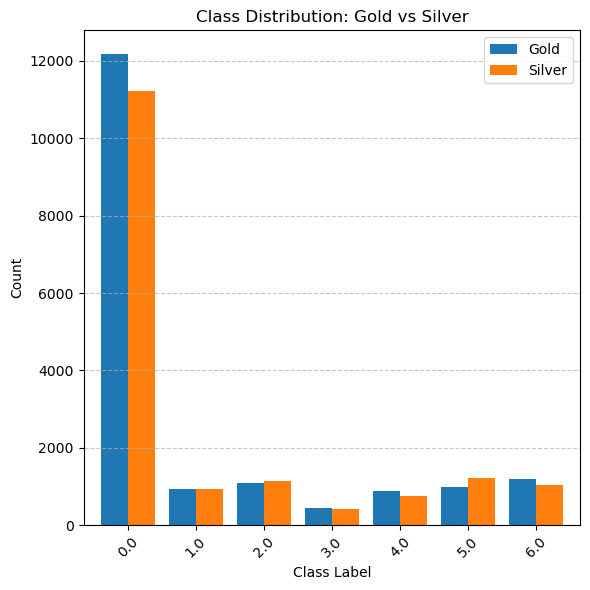

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Load results
df = pd.read_csv("results.csv", sep=";")  # Try semicolon


# Count occurrences of each class in gold and silver
gold_counts = df['labels1'].value_counts().sort_index()
silver_counts = df['labels2'].value_counts().sort_index()

# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Gold': gold_counts,
    'Silver': silver_counts
}).fillna(0).astype(int)

# Plot side-by-side bar chart
ax = comparison_df.plot(kind='bar', figsize=(6, 6), width=0.8)
plt.title("Class Distribution: Gold vs Silver")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Error Analysis

In [33]:
# Assumes labels1 = gold, labels2 = silver
df = pd.read_csv("results.csv", sep=";")  # Or your working version

# Missed ORG
missed_org = df[(df['labels1'] == 'ORG') & (df['labels2'] != 'ORG')]

# Hallucinated ORG (predicted ORG where it shouldn't be)
hallucinated_org = df[(df['labels1'] != 'ORG') & (df['labels2'] == 'ORG')]

# Misclassified ORG (could be either direction)
misclassified_org = df[(df['labels1'] == 'ORG') & (df['labels2'] != 'ORG')]


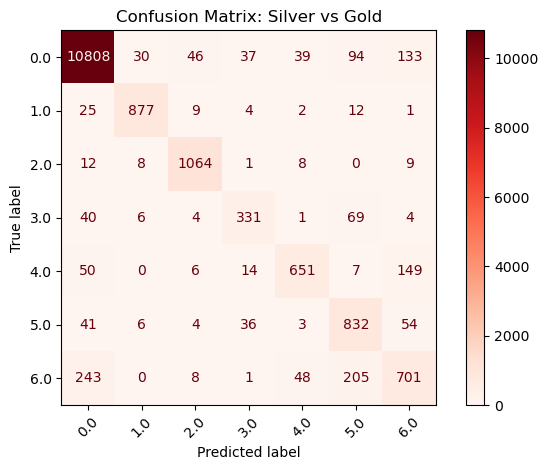

In [38]:
# Drop rows with missing labels
df_clean = df.dropna(subset=['labels1', 'labels2'])

# Extract gold and silver labels
y_true = df_clean['labels1']
y_pred = df_clean['labels2']

# Get consistent set of labels
labels = sorted(set(y_true) | set(y_pred))

# Now safely compute and display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Reds')
plt.title("Confusion Matrix: Silver vs Gold")
plt.tight_layout()
plt.show()
